<a id="toc"></a>
# Оглавление

[Введение](#intro)  
[Описание исходных данных и признаков](#data-desc)  
[Виртуальное окружение и импорты](#env)  
[1. Предварительная обработка данных](#sec-1)  
   [1.1. Чтение и загрузка данных](#sec-1-1)  
   [1.2. Первичный анализ данных](#sec-1-2)
   [1.3. Разделение на train/test](#sec-1-3)  
   [1.4. Обработка пропусков и кодирование категорий](#sec-1-4)  
   [1.5. Детекция выбросов и аномалий](#sec-1-5)  
   [1.6. Итоги раздела 1](#sec-1-6)  
[2. Генерация новых признаков](#sec-2)  
[3. Выбор моделей ML и метрик](#sec-3)  
[4. Обучение моделей ML и подбор гиперпараметров](#sec-4)  
[5. Вычисление метрик на новых данных](#sec-5)  
[6. Результат работы](#sec-6)  

<a id="intro"></a>
# Введение

[к оглавлению](#toc)

Задача — предсказать целевой показатель **«Гармония Бессмертия»** по измерениям параметров портала.

Это задача регрессии, так как целевая переменная числовая.

<a id="data-desc"></a>
## Описание исходных данных и признаков

[к оглавлению](#toc)

Данные — журнал измерений параметров портала. Каждая строка соответствует одному наблюдению, столбцы — признаки. Целевая переменная — `Гармония Бессмертия`.

### Таблица признаков

| Признак | Роль | Тип | Краткое описание |
| --- | --- | --- | --- |
| Вектор Мощи | входной | числовой | Позиция механизма, управляющего интенсивностью перехода. |
| Скорость перехода через портал | входной | числовой | Скорость перемещения объектов через портал. |
| Приток Силы Потока | входной | числовой | Поток силы через ядро портала. |
| Ритм магического ядра | входной | числовой | Обороты ядра в минуту. |
| Поток Энергий | входной | числовой | Обороты генератора эфира. |
| Сила Левого Потока | входной | числовой | Мощность левого потока. |
| Сила Правого Потока | входной | числовой | Мощность правого потока. |
| Пламя Стихий | входной | числовой | Температура энергии (°C). |
| Температура вдоха Истока | входной | числовой | Температура на входе (°C). |
| Температура выдоха Истока | входной | числовой | Температура на выходе (°C). |
| Приток давления Выдоха Истока | входной | числовой | Давление потока на выходе. |
| Давление вдоха Истока | входной (кандидат на удаление) | числовой | Давление на входе; близко к константе. |
| Давление выдоха Истока | входной | числовой | Давление на выходе. |
| Древний Ветер | входной (кандидат на удаление) | числовой | Признак с большим числом пропусков. |
| Печать Чародея | входной | числовой | Параметр управления, %. |
| Эмульсия Истока | входной | числовой | Количество топлива. |
| Дыхание Истока | входной | числовой | Коэффициент угасания ускорителя. |
| Гармония Бессмертия | целевой | числовой | Целевой показатель состояния ядра. |
| Тип Вектора Мощи | входной | категориальный | Категория: Слабый / Ниже среднего / Выше среднего / Сильный. |
| Номер пометки | служебный (удаляется) | целочисленный | Идентификатор записи. |

### Формулы предметной области

Допустимые (для генерации новых признаков):
- **Суммарная мощность потоков**: `Сила Левого Потока + Сила Правого Потока (+ Приток Силы Потока)`
- **Сила ядра**: `Ритм магического ядра * Приток Силы Потока`
- **Общее выходное давление**: `Приток давления Выдоха Истока + Давление выдоха Истока`
- **Магическая производительность**: `Скорость перехода через портал / Эмульсия Истока`
- **Эффективность ядра**: `Поток Энергий / Эмульсия Истока`
- **Мощность с температурным градиентом**: `(Пламя Стихий - Температура вдоха Истока) * (Приток давления Выдоха Истока + Давление выдоха Истока)`

<a id="env"></a>
## Виртуальное окружение и основные импорты

[к оглавлению](#toc)


In [44]:
import sys
!{sys.executable} -m pip uninstall pandas numpy scipy scikit-learn pyod -y

import sys
!{sys.executable} -m pip install numpy==1.23.5

import sys
!{sys.executable} -m pip install pandas==1.5.3

import sys
!{sys.executable} -m pip install scipy==1.10.1

import sys
!{sys.executable} -m pip install scikit-learn==1.2.2

import sys
!{sys.executable} -m pip install pyod==1.0.9

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

import sys
print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: pyod 1.0.9
Uninstalling pyod-1.0.9:
  Successfully uninstalled pyod-1.0.9
  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires pandas>=1.0.5, which is not installed.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, which is not installed.
category-encoders 2.7.0 requires scipy>=1.0.0, which is not installed.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, which is not installed.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, which is not installed.
lightgbm 4.6.0 requires scipy, which is not installed.
plotly-resampler 0.10.0 requires pandas>=1, which is not installed.
pmdarima 2.0.4 requires pandas>=0.19, which is not installed.
pmdarima 2.0.4 requires scikit-learn>=0.22, which is not installed.
pmdarima 2.0.4 requires scipy>=1.3.2, which is not installed.
pycaret 3.3.2 requires pandas<2.2.0, which is not installed.
pycaret 3.3.2 requires pyod>=1.1.3, which is not installed.
pycar

  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl.metadata (12 kB)
Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl (10.4 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, which is not installed.
category-encoders 2.7.0 requires scipy>=1.0.0, which is not installed.
pmdarima 2.0.4 requires scikit-learn>=0.22, which is not installed.
pmdarima 2.0.4 requires scipy>=1.3.2, which is not installed.
pycaret 3.3.2 requires pyod>=1.1.3, which is not installed.
pycaret 3.3.2 requires scikit-learn>1.4.0, which is not installed.
pycaret 3.3.2 requires scipy<=1.11.4,>=1.6.1, which is not installed.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, which is not installed.
sktime 0.26.0 requires scipy<2.0.0,>=1.2, which is not installed.
statsmodels 0.14.4 requires scipy!=1.9.2,>=1.8, which is not installed.
tbats 1.1.3 requires scikit-learn, which is not installed.
tbats 1.1.3 requires scipy, which is not installed.
pycaret 3.3.2 requi

  Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl.metadata (58 kB)
Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl (42.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, which is not installed.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, which is not installed.
pmdarima 2.0.4 requires scikit-learn>=0.22, which is not installed.
pycaret 3.3.2 requires pyod>=1.1.3, which is not installed.
pycaret 3.3.2 requires scikit-learn>1.4.0, which is not installed.
scikit-plot 0.3.7 requires scikit-learn>=0.18, which is not installed.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, which is not installed.
tbats 1.1.3 requires scikit-learn, which is not installed.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
pycaret 3.3.2 requires joblib<1.4,>=1.2.0, but you have joblib 1.5.2 which is incompatible

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.2 requires pyod>=1.1.3, which is not installed.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
pycaret 3.3.2 requires joblib<1.4,>=1.2.0, but you have joblib 1.5.2 which is incompatible.
pycaret 3.3.2 requires scikit-learn>1.4.0, but you have scikit-learn 1.2.2 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl (8.3 MB)
  Using cached pyod-1.0.9-py3-none-any.whl
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.23.5

   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-1.23.5:
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
      Successfully uninstalled numpy-1.23.5
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
pycaret 3.3.2 requires joblib<1.4,>=1.2.0, but you have joblib 1.5.2 which is incompatible.
pycaret 3.3.2 requires pyod>=1.1.3, but you have pyod 1.0.9 which is incompatible.
pycaret 3.3.2 requires scikit-learn>1.4.0, but you have scikit-learn 1.2.2 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<a id="sec-1"></a>
# 1. Предварительная обработка данных

[к оглавлению](#toc)

<a id="sec-1-1"></a>
## 1.1. Чтение и загрузка данных

[к оглавлению](#toc)

In [45]:
encodings = ["cp1251", "utf-8", "utf-8-sig", "latin-1"]

detected = None
for enc in encodings:
    try:
        _tmp = pd.read_csv('../data/portal_data.csv', encoding=enc, nrows=3)
        detected = enc
        break
    except Exception:
        pass

print(f"Кодировка: {detected}")
_tmp


Кодировка: cp1251


,Вектор Мощи|Скорость перехода через портал|Приток Силы Потока|Ритм магического ядра|Поток Энергий|Сила Левого Потока|Сила Правого Потока|Пламя Стихий|Температура вдоха Истока|Температура выдоха Истока|Приток давления Выдоха Истока|Давление вдоха Истока|Давление выдоха Истока|Древний Ветер|Печать Чародея|Эмульсия Истока|Дыхание Истока|Гармония Бессмертия|Тип Вектора Мощи|Номер пометки
0,1.138|1.54332|289.964|141.31815761667454|6677....
1,2.088|-|6960.18|144.1117665240017|6828.469|28....
2,3.144|4.6299600000000005|8379.229|145.22085345...


Правильно заменим пропуски на более корректные значения и правилльно прочитаеем csv

In [46]:
data = pd.read_csv('../data/portal_data.csv', encoding=detected, sep="|")

data = data.replace("-", np.nan).replace("Не определено", np.nan)

print(data.shape)
data.head(10)


(11934, 20)


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4
5,6.175,9.25992,29792.731,241.630782,8828.360,246.278,246.278,800.434,736,676.397,2.501,NaN,13.356,1.03,35.760,0.708,0.95,0.975,Выше среднего,5
6,7.148,10.80324,38982.180,280.448510,9132.429,332.077,332.077,854.747,736,NaN,2.963,NaN,15.679,NaN,45.881,0.908,0.95,0.975,Сильный,6
7,8.206,12.34656,50996.808,323.328632,9318.562,437.989,437.989,952.122,736,NaN,3.576,NaN,18.632,NaN,62.440,1.236,0.95,0.975,Сильный,7
8,9.300,13.88988,72763.329,372.843693,9778.528,644.905,644.905,1115.797,736,NaN,4.498,1.394603,22.811,NaN,92.556,1.832,0.95,0.975,Сильный,8
9,1.138,1.54332,379.880,141.934538,6683.916,7.915,7.915,464.017,736,550.985,1.100,NaN,5.963,1.019,3.879,0.079,0.95,0.976,Слабый,9


<a id="sec-1-2"></a>
## 1.2. Первичный анализ данных

[к оглавлению](#toc)

Приведение типов признаков (числовые/категориальные) и базовая сводка по таблице (пропуски, служебные поля).

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  10731 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       2387 non-null   object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           2439 non-null   object 
 12  Давление выдоха Истока          

Переведем в боллее корректные типы после анализа датасета и просмотра типов столбцов

In [48]:
obj_to_float = [
    "Скорость перехода через портал",
    "Температура выдоха Истока",
    "Древний Ветер",
    "Давление вдоха Истока"
]

for c in obj_to_float:
    data[c] = pd.to_numeric(data.get(c), errors="coerce")

data["Номер пометки"] = pd.to_numeric(data["Номер пометки"], errors="coerce").astype("Int64")
data["Тип Вектора Мощи"] = data["Тип Вектора Мощи"].astype("category")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Вектор Мощи                     11934 non-null  float64 
 1   Скорость перехода через портал  10731 non-null  float64 
 2   Приток Силы Потока              11934 non-null  float64 
 3   Ритм магического ядра           11934 non-null  float64 
 4   Поток Энергий                   11934 non-null  float64 
 5   Сила Левого Потока              11934 non-null  float64 
 6   Сила Правого Потока             11934 non-null  float64 
 7   Пламя Стихий                    11934 non-null  float64 
 8   Температура вдоха Истока        11934 non-null  int64   
 9   Температура выдоха Истока       2387 non-null   float64 
 10  Приток давления Выдоха Истока   11934 non-null  float64 
 11  Давление вдоха Истока           2439 non-null   float64 
 12  Давление выдоха Ис

In [49]:
data

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,7.71660,21624.934,201.516623,8470.013,175.239,175.239,681.658,736,628.950,2.087,NaN,10.990,1.027,23.803,0.471,1.00,1.000,Выше среднего,11929
11930,6.175,9.25992,29763.213,241.561772,8800.352,245.954,245.954,747.405,736,NaN,2.512,NaN,13.109,NaN,32.671,0.647,1.00,1.000,Выше среднего,11930
11931,7.148,10.80324,39003.867,280.444950,9120.889,332.389,332.389,796.457,736,680.393,2.982,NaN,15.420,1.036,42.104,0.834,1.00,1.000,Сильный,11931
11932,8.206,12.34656,50992.579,323.315332,9300.274,438.024,438.024,892.945,736,NaN,3.594,NaN,18.293,NaN,58.064,1.149,1.00,1.000,Сильный,11932


Удалим столбец с индексами и постоянными значениями

In [50]:
drop_cols = ["Номер пометки","Температура вдоха Истока"]
data = data.drop(columns=drop_cols)

print("После удаления:", data.shape)
data.head()


После удаления: (11934, 18)


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего


<a id="sec-1-3"></a>
## 1.3. Разделение выборки на обучающую и тестовую выборки

[к оглавлению](#toc)

Разбиение на обучающую и тестовую выборки.

Древний Ветер                     9547
Температура выдоха Истока         9547
Давление вдоха Истока             9495
Скорость перехода через портал    1203
Вектор Мощи                          0
Гармония Бессмертия                  0
Дыхание Истока                       0
Эмульсия Истока                      0
Печать Чародея                       0
Давление выдоха Истока               0
dtype: int64


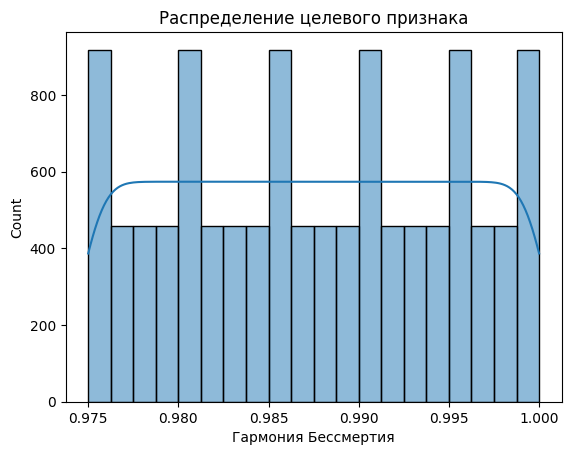

Train shape: (9547, 17), Test shape: (2387, 17)


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data.isna().sum().sort_values(ascending=False).head(10))
sns.histplot(data["Гармония Бессмертия"], bins=20, kde=True)
plt.title("Распределение целевого признака")
plt.show()

X = data.drop(columns=["Гармония Бессмертия"])
y = data["Гармония Бессмертия"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

<a id="sec-1-4"></a>
## 1.4. Обработка вещественных признаков (заполнение пропусков)

[к оглавлению](#toc)

Заполнение пропусков в числовых признаках.

Этапы:

- кодирование категориального признака `Тип Вектора Мощи` в числовой вид;
- статистическое заполнение (выбор mean/median/mode по минимальной KL-дивергенции);
- заполнение с помощью `KNNImputer`.

### Кодировка категориального признака

Категориальный признак `Тип Вектора Мощи` преобразуется в порядковый числовой формат (с фиксированным порядком категорий).

In [ ]:

cat_columns = X_train.select_dtypes(include=['object', 'category'])
print(cat_columns)


print("Уникальные значения в X_train['Тип Вектора Мощи']:")
print(X_train["Тип Вектора Мощи"].unique())

      Тип Вектора Мощи
3685     Выше среднего
5886            Слабый
6108           Сильный
7713            Слабый
3499           Сильный
...                ...
11284          Сильный
5191           Сильный
5390           Сильный
860      Выше среднего
7270           Сильный

[9547 rows x 1 columns]
Уникальные значения в X_train['Тип Вектора Мощи']:
['Выше среднего', 'Слабый', 'Сильный', 'Ниже среднего']
Categories (4, object): ['Выше среднего', 'Ниже среднего', 'Сильный', 'Слабый']


Зададим парядок вручную и применим к трейну и тесту

In [ ]:

label_mapping = {
    "Слабый": 0,
    "Ниже среднего": 1,
    "Выше среднего": 2,
    "Сильный": 3
}


X_train["Тип Вектора Мощи"] = X_train["Тип Вектора Мощи"].map(label_mapping)


In [54]:
X_test["Тип Вектора Мощи"] = X_test["Тип Вектора Мощи"].map(label_mapping)
X_train.head(10)

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Тип Вектора Мощи
3685,5.140,NaN,21634.909,201.516309,8497.497,175.278,175.278,704.972,NaN,2.078,NaN,11.004,NaN,24.951,0.494,0.965,2
5886,1.138,1.54332,2706.698,138.966361,6622.351,6.270,6.270,545.800,NaN,1.184,NaN,6.450,NaN,26.222,0.194,0.975,0
6108,7.148,10.80324,38998.248,280.444531,9120.644,332.275,332.275,835.034,NaN,2.980,NaN,15.730,NaN,44.789,0.887,0.976,3
7713,1.138,1.54332,6763.006,144.782287,6697.636,9.375,9.375,620.925,NaN,1.322,NaN,7.078,NaN,0.000,0.278,0.982,0
3499,8.206,12.34656,50994.067,323.324443,9319.460,438.106,438.106,917.854,NaN,3.566,NaN,18.180,NaN,59.577,1.179,0.964,3
4963,5.140,7.71660,21630.599,201.513796,8479.072,175.272,175.272,715.290,NaN,2.084,1.394603,11.171,NaN,25.585,0.506,0.971,2
4091,6.175,9.25992,29791.466,241.633505,8822.265,246.201,246.201,778.048,NaN,2.504,NaN,13.224,NaN,34.448,0.682,0.967,2
6489,1.138,1.54332,3346.542,148.184423,6712.135,11.322,11.322,529.705,NaN,1.221,NaN,6.532,NaN,0.000,0.162,0.977,0
1379,3.144,4.62996,8380.957,145.222005,7159.710,60.377,60.377,585.006,NaN,1.387,NaN,7.410,NaN,12.226,0.242,0.955,1
9440,9.300,13.88988,72763.303,372.841912,9738.873,644.962,644.962,1063.563,NaN,4.538,NaN,22.854,NaN,88.590,1.754,0.990,3


Посмотрим количество пропусков в трейна по каждому столбцу

In [ ]:

print("Пропуски в X_train:")
print(X_train.isna().sum())

Пропуски в X_train:
Вектор Мощи                          0
Скорость перехода через портал     961
Приток Силы Потока                   0
Ритм магического ядра                0
Поток Энергий                        0
Сила Левого Потока                   0
Сила Правого Потока                  0
Пламя Стихий                         0
Температура выдоха Истока         7160
Приток давления Выдоха Истока        0
Давление вдоха Истока             7603
Давление выдоха Истока               0
Древний Ветер                     7160
Печать Чародея                       0
Эмульсия Истока                      0
Дыхание Истока                       0
Тип Вектора Мощи                     0
dtype: int64


Удали столбцы, где много пропусков

In [ ]:

X_train = X_train.drop(columns=["Древний Ветер", "Давление вдоха Истока", "Температура выдоха Истока"])
X_test = X_test.drop(columns=["Древний Ветер", "Давление вдоха Истока", "Температура выдоха Истока"])


num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
print("Числовые столбцы:", num_cols)

Числовые столбцы: ['Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока', 'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока', 'Сила Правого Потока', 'Пламя Стихий', 'Приток давления Выдоха Истока', 'Давление выдоха Истока', 'Печать Чародея', 'Эмульсия Истока', 'Дыхание Истока']


### Статистическое заполнение пропусков (KL-дивергенция)

Для признаков с пропусками выбирается значение заполнения (mean/median) по критерию минимальной KL-дивергенции между распределениями до/после заполнения.


Анализ признака: Скорость перехода через портал
  mean: KL = 0.106094
  median: KL = 0.028762


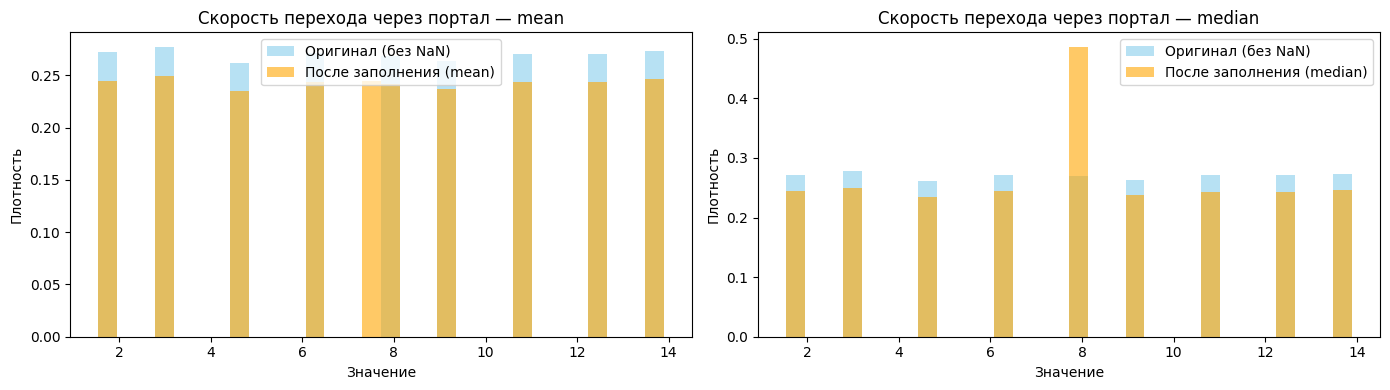

Выбрано: median = 7.7166 (KL = 0.028762)



In [ ]:

from scipy.stats import entropy

def kl_div(p, q):
    p = np.array(p) + 1e-10  # избегаем log(0)
    q = np.array(q) + 1e-10
    p = p / p.sum()
    q = q / q.sum()
    return entropy(p, q)


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy


best_fill_values = {}

for col in num_cols:
    if X_train[col].isna().sum() == 0:
        continue

    print(f"\nАнализ признака: {col}")
    orig = X_train[col].dropna()

    
    candidates = {
        'mean': orig.mean(),
        'median': orig.median()
    }

    best_kl = float('inf')
    best_val = candidates['median']
    best_name = 'median'

    
    plt.figure(figsize=(14, 4))

    for i, (name, val) in enumerate(candidates.items(), 1):
        
        filled = X_train[col].fillna(val)

        
        plt.subplot(1, 2, i)
        plt.hist(orig, bins=30, alpha=0.6, label='Оригинал (без NaN)', density=True, color='skyblue')
        plt.hist(filled, bins=30, alpha=0.6, label=f'После заполнения ({name})', density=True, color='orange')
        plt.title(f'{col} — {name}')
        plt.xlabel('Значение')
        plt.ylabel('Плотность')
        plt.legend()

       
        hist_orig, bins = np.histogram(orig, bins=30, density=True)
        hist_filled, _ = np.histogram(filled, bins=bins, density=True)
        kl = kl_div(hist_orig, hist_filled)
        print(f"  {name}: KL = {kl:.6f}")

        if kl < best_kl:
            best_kl = kl
            best_val = val
            best_name = name

    plt.tight_layout()
    plt.show()  

    best_fill_values[col] = best_val
    print(f"Выбрано: {best_name} = {best_val:.4f} (KL = {best_kl:.6f})\n")

Применим изменения и к трейну и к тесту

In [ ]:

X_train_stat = X_train.copy()
X_test_stat = X_test.copy()

for col, fill_val in best_fill_values.items():
    X_train_stat[col] = X_train_stat[col].fillna(fill_val)
    X_test_stat[col] = X_test_stat[col].fillna(fill_val)

print(" Статистическое заполнение завершено.")

 Статистическое заполнение завершено.


Заполнил пропуски в «Скорость перехода через портал» значением, выбранным по минимальной KL‑дивергенции (сравнивались варианты mean/median). Признак дискретный, поэтому распределение выглядит как набор отдельных столбиков. После заполнения увеличилась частота выбранного значения — это ожидаемый эффект при заполнении константой. При этом выбранное значение минимально искажает исходное распределение по критерию KL, поэтому такое заполнение можно считать адекватным для дальнейшего обучения моделей.

### Машинное заполнение пропусков 

Заполнение пропусков методом `IterativeImputer` на основе ближайших соседей (обучение на train, применение к test).

In [ ]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


iter_imp = IterativeImputer(random_state=42, max_iter=10)



In [ ]:

X_train_iter = pd.DataFrame(
    iter_imp.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_iter = pd.DataFrame(
    iter_imp.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


print(" Машинное заполнение (IterativeImputer) завершено.")

 Машинное заполнение (IterativeImputer) завершено.


#### Сравнение распределений 



Сравним результаты заполнений и будем работать с тем, у которого лучще метрика

In [61]:
def compare_distributions(original, filled, col_name):
    hist_orig, bins = np.histogram(original.dropna(), bins=30, density=True)
    hist_filled, _ = np.histogram(filled, bins=bins, density=True)
    kl = kl_div(hist_orig, hist_filled)
    print(f"{col_name}: KL = {kl:.6f}")
    return kl

# Пример для одного признака
col = "Скорость перехода через портал"
orig = X_train[col]

kl_stat = compare_distributions(orig, X_train_stat[col], "Статистическое")
kl_iter = compare_distributions(orig, X_train_iter[col], "Машинное")

print(f"\nЛучше сохраняет распределение: {'Статистическое' if kl_stat < kl_iter else 'Машинное'}")

Статистическое: KL = 0.028762
Машинное: KL = 0.011633

Лучше сохраняет распределение: Машинное


Проверим что заполнились все пропуски

In [62]:
print("Проверка пропусков:")
print("Статистический — train:", X_train_stat.isna().sum().sum())
print("Статистический — test: ", X_test_stat.isna().sum().sum())
print("Машинный — train:      ", X_train_iter.isna().sum().sum())
print("Машинный — test:       ", X_test_iter.isna().sum().sum())

Проверка пропусков:
Статистический — train: 0
Статистический — test:  0
Машинный — train:       0
Машинный — test:        0


<a id="sec-1-5"></a>
## 1.5. Детекция выбросов и аномалий в данных

[к оглавлению](#toc)

Очистка обучающей выборки:

- выбросы: IQR и Robust Z-score (используется пересечение);
- аномалии: Isolation Forest, One-class SVM, DBSCAN (удаляем строки, которые попали в пересечение аномалий).

Построение диаграмм 'ящик с усами' для обучающей выборки...



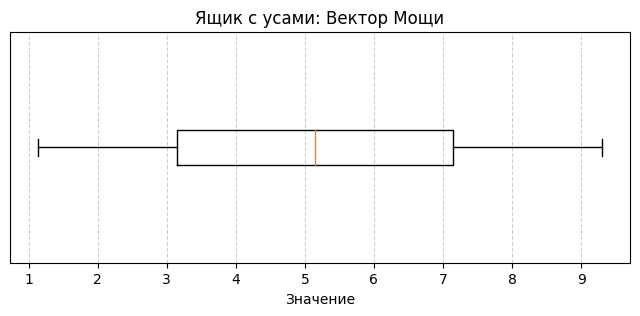

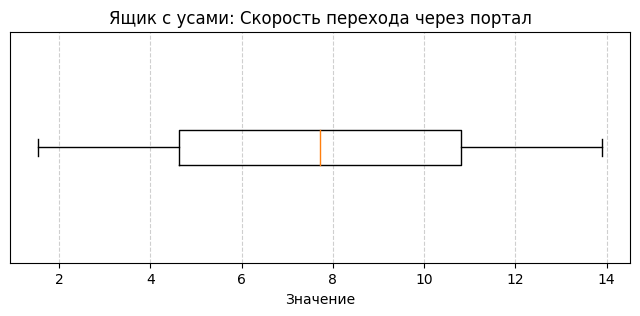

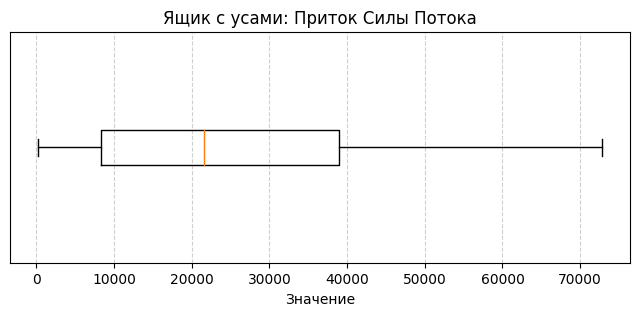

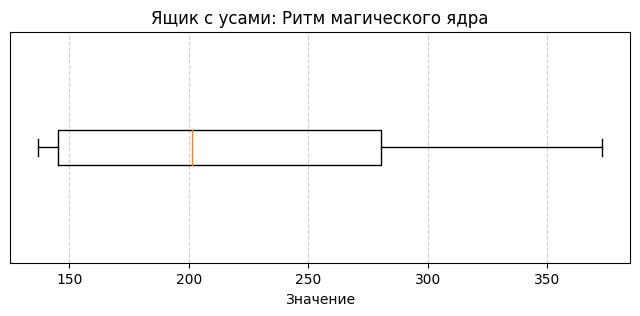

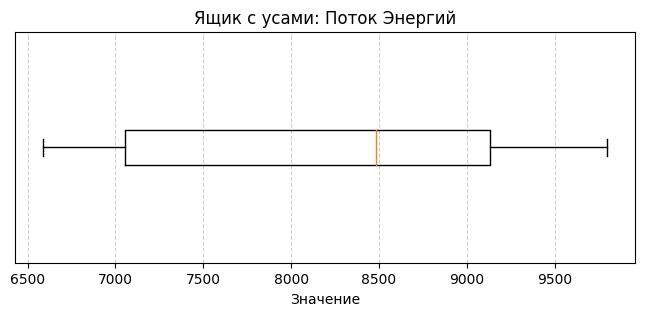

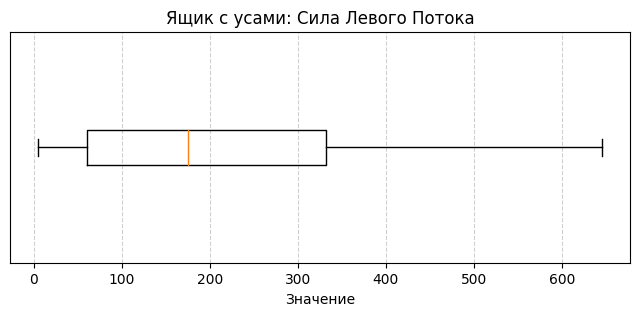

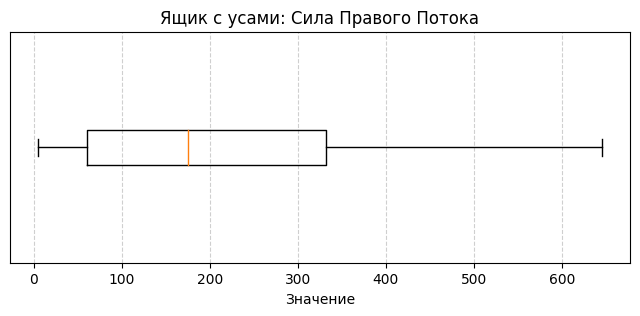

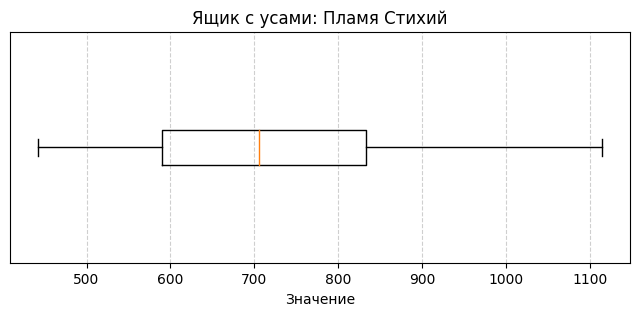

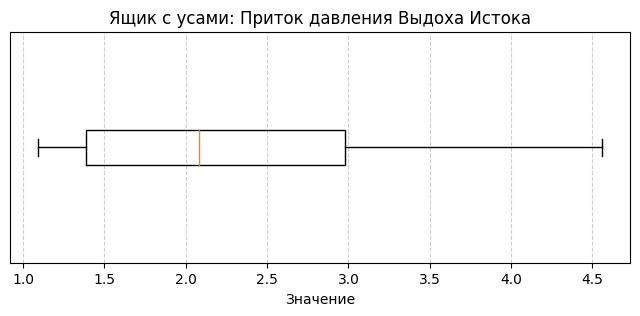

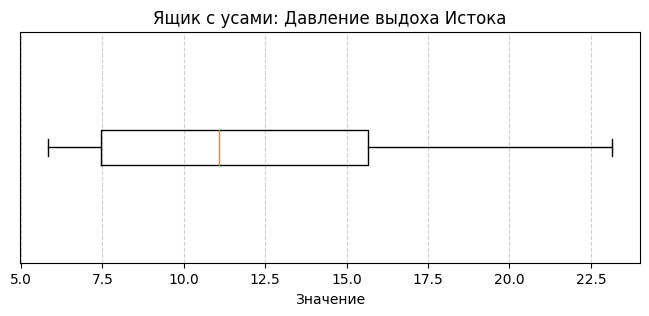

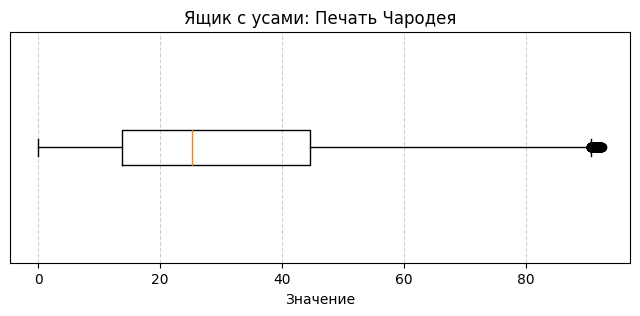

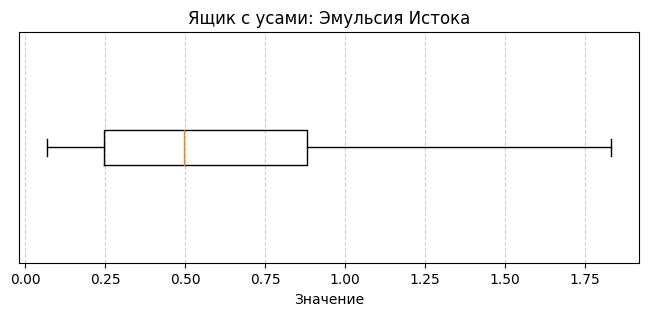

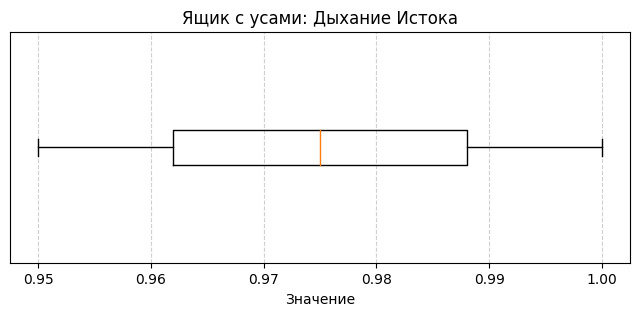

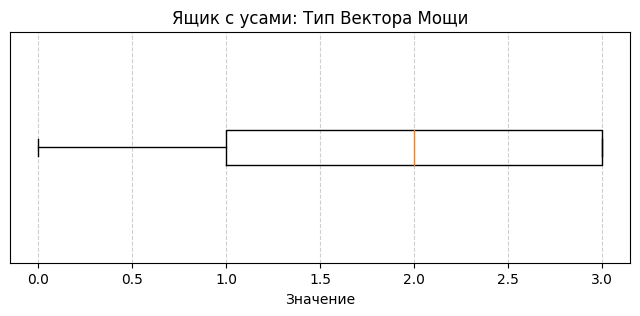

In [ ]:
import matplotlib.pyplot as plt


num_cols = X_train_iter.select_dtypes(include=['number']).columns.tolist()

print("Построение диаграмм 'ящик с усами' для обучающей выборки...\n")


for col in num_cols:
    plt.figure(figsize=(8, 3))
    plt.boxplot(X_train_iter[col].dropna(), vert=False)
    plt.title(f'Ящик с усами: {col}')
    plt.xlabel('Значение')
    plt.yticks([])  # убираем подпись оси Y
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
    
    
    

По диаграммам «ящик с усами» видно, что распределения признаков сильно отличаются по масштабу и форме.

- Для части признаков наблюдается выраженная асимметрия и «длинные усы» вправо (например, потоки/мощности и давления) — это признак наличия редких, но очень больших значений. Такие наблюдения потенциально являются выбросами и могут смещать обучение моделей (особенно чувствительных к масштабу и экстремальным значениям).
- У некоторых признаков разброс умеренный и основная масса значений лежит компактно (коробка относительно узкая), однако при этом встречаются точки далеко за пределами «усов» — например, у `Печать Чародея` заметен одиночный экстремум, который явно отличается от основной выборки.
- Есть признаки с очень малой вариативностью: `Дыхание Истока` почти постоянно около 1 (коробка узкая, усы короткие). Такие признаки слабо информативны и могут плохо влиять на методы, основанные на расстояниях, если не выполнить нормализацию.
- `Вектор Мощи` и `Тип Вектора Мощи` выглядят дискретными (ступенчатая структура), что объясняется ограниченным числом возможных значений.

В целом графики подтверждают, что в данных присутствуют выбросы, поэтому дальше оправдано применение формальных методов поиска выбросов (IQR и Robust Z-score) и удаление только тех строк, которые подтверждаются обоими критериями (пересечение), чтобы снизить риск удалить «нормальные» наблюдения.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

def find_outliers_iqr(series, factor=1.5):
    """Возвращает маску (True — выброс) по методу IQR."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (series < lower_bound) | (series > upper_bound)

def find_outliers_robust_z(series, threshold=3.0):
    """Возвращает маску (True — выброс) по Robust Z-score."""
    median = series.median()
    mad = median_abs_deviation(series, nan_policy='omit')
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    robust_z = 0.6745 * (series - median) / mad
    return np.abs(robust_z) > threshold

cols_with_outliers = [
    "Печать Чародея"
]

outlier_indices = set() 

for col in cols_with_outliers:
    print(f"\nАнализ признака: {col}")
    
    
    
    iqr_mask = find_outliers_iqr(X_train_iter[col])
    z_mask = find_outliers_robust_z(X_train_iter[col])
    
   
    combined_mask = iqr_mask & z_mask
    outlier_rows = X_train_iter[combined_mask].index.tolist()
    
    print(f"  Выбросов по IQR: {iqr_mask.sum()}")
    print(f"  Выбросов по Robust Z: {z_mask.sum()}")
    print(f"  В пересечении: {len(outlier_rows)}")
    
    
    outlier_indices.update(outlier_rows)


Анализ признака: Печать Чародея
  Выбросов по IQR: 186
  Выбросов по Robust Z: 1063
  В пересечении: 186


In [ ]:

X_train_iter_iqr = X_train_iter.drop(index=outlier_indices)
y_train_iqr = y_train.drop(index=outlier_indices)

По методу IQR нашлось умеренное число выбросов (186 строк). Robust Z-score при выбранном пороге `thresh = 3` оказался более чувствительным и отметил больше “подозрительных” наблюдений (1063 строки). В финальный набор выбросов берём только строки, которые одновременно считаются выбросами и по IQR, и по Robust Z-score. В нашем случае пересечение получилось 186 строк — именно они и будут удалены из обучающей выборки как наиболее очевидные выбросы.

### Поиск аномалий (Isolation Forest, One-class SVM, DBSCAN)

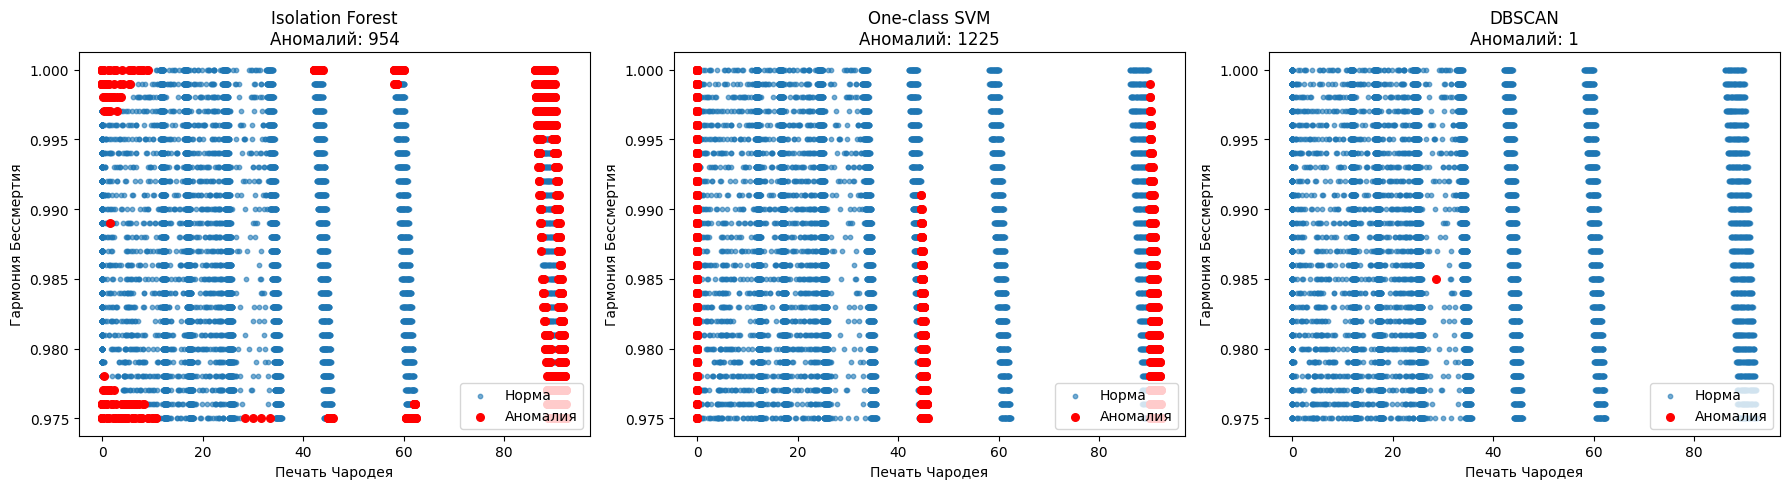

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN


col= "Печать Чародея"


 
X_2d = X_train_iter[[col]].copy()
X_2d['Гармония Бессмертия'] = y_train.values
X_2d_np = X_2d.values


iforest = IsolationForest(contamination=0.1, random_state=42)
iforest_labels = iforest.fit_predict(X_2d_np)
anomalies_iforest = (iforest_labels == -1)  # в sklearn: -1 = аномалия


ocsvm = OneClassSVM(nu=0.1)  # nu ≈ contamination
ocsvm_labels = ocsvm.fit_predict(X_2d_np)
anomalies_ocsvm = (ocsvm_labels == -1)


dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_2d_np)
anomalies_dbscan = (dbscan_labels == -1)  # шум = -1 → аномалия

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ("Isolation Forest", anomalies_iforest),
    ("One-class SVM", anomalies_ocsvm),
    ("DBSCAN", anomalies_dbscan)
]

for ax, (name, mask) in zip(axes, methods):
    ax.scatter(X_2d_np[~mask, 0], X_2d_np[~mask, 1], s=10, alpha=0.6, label='Норма')
    ax.scatter(X_2d_np[mask, 0], X_2d_np[mask, 1], s=30, color='red', label='Аномалия')
    ax.set_title(f"{name}\nАномалий: {mask.sum()}")
    ax.set_xlabel(col)
    ax.set_ylabel('Гармония Бессмертия')
    ax.legend()

plt.tight_layout()
plt.show()

In [67]:
# Аномалия, если все три алгоритма её нашли
final_anomalies = anomalies_iforest & anomalies_ocsvm 

print(f"Аномалий по каждому методу:")
print(f"  Isolation Forest: {anomalies_iforest.sum()}")
print(f"  One-class SVM:    {anomalies_ocsvm.sum()}")
print(f"  DBSCAN:           {anomalies_dbscan.sum()}")
print(f"  В пересечении:    {final_anomalies.sum()}")

# Индексы аномальных строк
anomaly_indices = X_2d[final_anomalies].index
print(f"\nИндексы для удаления: {anomaly_indices.tolist()}")

Аномалий по каждому методу:
  Isolation Forest: 954
  One-class SVM:    1225
  DBSCAN:           1
  В пересечении:    354

Индексы для удаления: [7713, 620, 3068, 1889, 2015, 7037, 5608, 449, 530, 6101, 431, 782, 440, 10053, 2249, 6076, 6535, 872, 11701, 476, 6560, 474, 1349, 2574, 6778, 2870, 5885, 809, 1880, 8893, 2177, 1034, 9604, 5140, 1259, 3077, 3329, 323, 1097, 6110, 2375, 3527, 5651, 3285, 1313, 611, 2114, 6092, 2861, 1808, 3761, 1295, 3050, 9585, 818, 1043, 3095, 332, 1395, 1115, 1052, 6119, 1322, 5833, 1025, 3320, 485, 2132, 350, 9342, 6301, 5399, 6067, 7966, 1502, 1070, 503, 1176, 693, 413, 5156, 1223, 5183, 2636, 942, 179, 737, 800, 377, 3518, 773, 962, 2825, 1410, 11691, 4715, 5165, 1152, 665, 26, 1916, 1133, 9838, 6794, 2331, 1340, 1583, 1412, 5417, 1754, 6569, 8902, 1781, 548, 3986, 2888, 6578, 296, 2580, 8406, 2112, 684, 998, 494, 1079, 4229, 8191, 1547, 9117, 8425, 4472, 755, 746, 7496, 170, 242, 1644, 5856, 305, 143, 1161, 1878, 44, 1187, 4013, 4686, 4922, 240, 1620,

Isolation Forest и One-class SVM дают очень похожую картину — они отмечают примерно одни и те же “подозрительные” точки. DBSCAN работает по плотности, поэтому он выделяет аномалии по‑другому: видно, что он “цепляется” за отдельные области/группы точек, а не повторяет первые два метода. В итоге модели между собой не сходятся и финальный набор аномалий получается нулевым, поэтому удалим выбросы которые получились не полсе пересечения всеми 3-мя методами, а первыми 2-мя (без DBSCAN)

In [68]:
X_train_iter_ansambl = X_train_iter.drop(index=anomaly_indices)
y_train_ansambl = y_train.drop(index=anomaly_indices)
print(f"Финальный размер train: {X_train_iter_ansambl.shape[0]}")

Финальный размер train: 9193


In [69]:
def compare_stats(X_orig, X_clean, name, col):
    orig = X_orig[col].dropna()
    clean = X_clean[col]
    print(f"{name}:")
    print(f"  IQR: {orig.quantile(0.75)-orig.quantile(0.25):.3f} → {clean.quantile(0.75)-clean.quantile(0.25):.3f}")
    print(f"  std: {orig.std():.3f} → {clean.std():.3f}")
    print(f"  медиана: {orig.median():.3f} → {clean.median():.3f}")
    print()

compare_stats(X_train_iter, X_train_iter_iqr, "IQR + Z-score", col)
compare_stats(X_train_iter, X_train_iter_ansambl, "Ансамбль", col)

IQR + Z-score:
  IQR: 30.773 → 31.209
  std: 25.852 → 24.780
  медиана: 25.242 → 25.123

Ансамбль:
  IQR: 30.773 → 30.471
  std: 25.852 → 24.353
  медиана: 25.242 → 25.123



Посмотрим на результаты метрик и поймем что лучще показали себя последние 3 метода:Isolation Forest и One-class SVM,DBSCAN, поэтому дальше будем работать с результатом после этих методов

<a id="sec-1-6"></a>
## 1.6. Подведение итогов раздела 1

[к оглавлению](#toc)

Итог:

- загрузка данных и приведение типов;
- удаление служебных/неинформативных признаков;
- разбиение train/test;
- заполнение пропусков , кодирование `Тип Вектора Мощи`;
- очистка обучающей выборки от выбросов и аномалий.

Дальнейшая работа ведётся на `X_train_iter_ansambl`, `y_train_ansambl`. Тестовая выборка — `X_test_iter`.

<a id="sec-2"></a>
# 2. Генерация новых признаков

[к оглавлению](#toc)

<a id="sec-2-1"></a>
## 2.1. Корреляционный анализ входных признаков (построение тепловых карт корреляции)

[к оглавлению](#toc)

Корреляционный анализ числовых признаков и выявление сильных зависимостей.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пирсона
corr_matrix = X_train_iter_ansambl.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,          # показывать числа в ячейках
    fmt=".2f",           # формат: 2 знака после запятой
    cmap="coolwarm",     # цветовая схема: синий (-1), белый (0), красный (+1)
    center=0,            # центр цвета — 0
    square=True,         # ячейки — квадраты
    cbar_kws={"shrink": 0.8}
)

plt.title("Тепловая карта корреляции признаков", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

NameError: name 'X_train_iter_ansambl' is not defined

Тепловая карта показывает, что многие признаки очень сильно коррелируют между собой (есть прям почти “одинаковые” по смыслу/формуле). Это плохой сигнал для линейных моделей: появляется мультиколлинеарность и модель может быть нестабильной. Поэтому дальше логично делать feature engineering (агрегаты) и/или убирать часть дублей.

<a id="sec-2-2"></a>
## 2.2. Исправление проблемы мультиколлинеарности в данных

[к оглавлению](#toc)

Снижение мультиколлинеарности: генерация агрегированных признаков по формулам предметной области и исключение части исходных признаков с высокой корреляцией.

In [71]:

X_train_iter_ansambl['Общая мощность потоков'] = (
    X_train_iter_ansambl['Приток Силы Потока'] +
    X_train_iter_ansambl['Сила Левого Потока'] +
    X_train_iter_ansambl['Сила Правого Потока']
)

X_test_iter['Общая мощность потоков'] = (
    X_test_iter['Приток Силы Потока'] +
    X_test_iter['Сила Левого Потока'] +
    X_test_iter['Сила Правого Потока']
)

In [72]:

X_train_iter_ansambl['Общая сила потоков'] = (
    X_train_iter_ansambl['Сила Левого Потока'] -
    X_train_iter_ansambl['Сила Правого Потока']
)

X_test_iter['Общая сила потоков'] = (
    X_test_iter['Сила Левого Потока'] -
    X_test_iter['Сила Правого Потока']
)

In [73]:
X_train_iter_ansambl['Общее Давление на выдохе'] = (
    X_train_iter_ansambl['Давление выдоха Истока'] +
    X_train_iter_ansambl['Приток давления Выдоха Истока']
)

X_test_iter['Общее Давление на выдохе'] = (
    X_test_iter['Давление выдоха Истока'] +
    X_test_iter['Приток давления Выдоха Истока']
)

In [74]:
X_train_iter_ansambl['Магическая Производительность'] = (
    X_train_iter_ansambl['Скорость перехода через портал'] /
    X_train_iter_ansambl['Эмульсия Истока']
)

X_test_iter['Магическая Производительность'] = (
    X_test_iter['Скорость перехода через портал'] /
    X_test_iter['Эмульсия Истока']
)

In [75]:
X_train_iter_ansambl['Эффективность Ядра'] = (
    X_train_iter_ansambl['Ритм магического ядра'] *
    X_train_iter_ansambl['Приток Силы Потока'] /
    X_train_iter_ansambl['Эмульсия Истока']
)

X_test_iter['Эффективность Ядра'] = (
    X_test_iter['Ритм магического ядра'] *
    X_test_iter['Приток Силы Потока'] /
    X_test_iter['Эмульсия Истока']
)


In [76]:
# Избегаем деления на ноль
eps = 1e-8

X_train_iter_ansambl['Соотношение мощности к давлению'] = (
    X_train_iter_ansambl['Общая мощность потоков'] /
    (X_train_iter_ansambl['Общее Давление на выдохе'] + eps)
)

X_test_iter['Соотношение мощности к давлению'] = (
    X_test_iter['Общая мощность потоков'] /
    (X_test_iter['Общее Давление на выдохе'] + eps)
)

In [77]:
#Удалим старые признаки чтоб сохранить размерность
X_train_final = X_train_iter_ansambl.drop(columns=[
    'Приток Силы Потока',
    'Сила Левого Потока',
    'Сила Правого Потока',
    'Давление выдоха Истока',
    'Приток давления Выдоха Истока',
    'Ритм магического ядра',
    'Приток Силы Потока',
    'Общая мощность потоков',
    'Общее Давление на выдохе'
])

X_test_final = X_test_iter.drop(columns=[
    'Приток Силы Потока',
    'Сила Левого Потока',
    'Сила Правого Потока',
    'Давление выдоха Истока',
    'Приток давления Выдоха Истока',
    'Ритм магического ядра',
    'Приток Силы Потока',
    'Общая мощность потоков',
    'Общее Давление на выдохе'
])

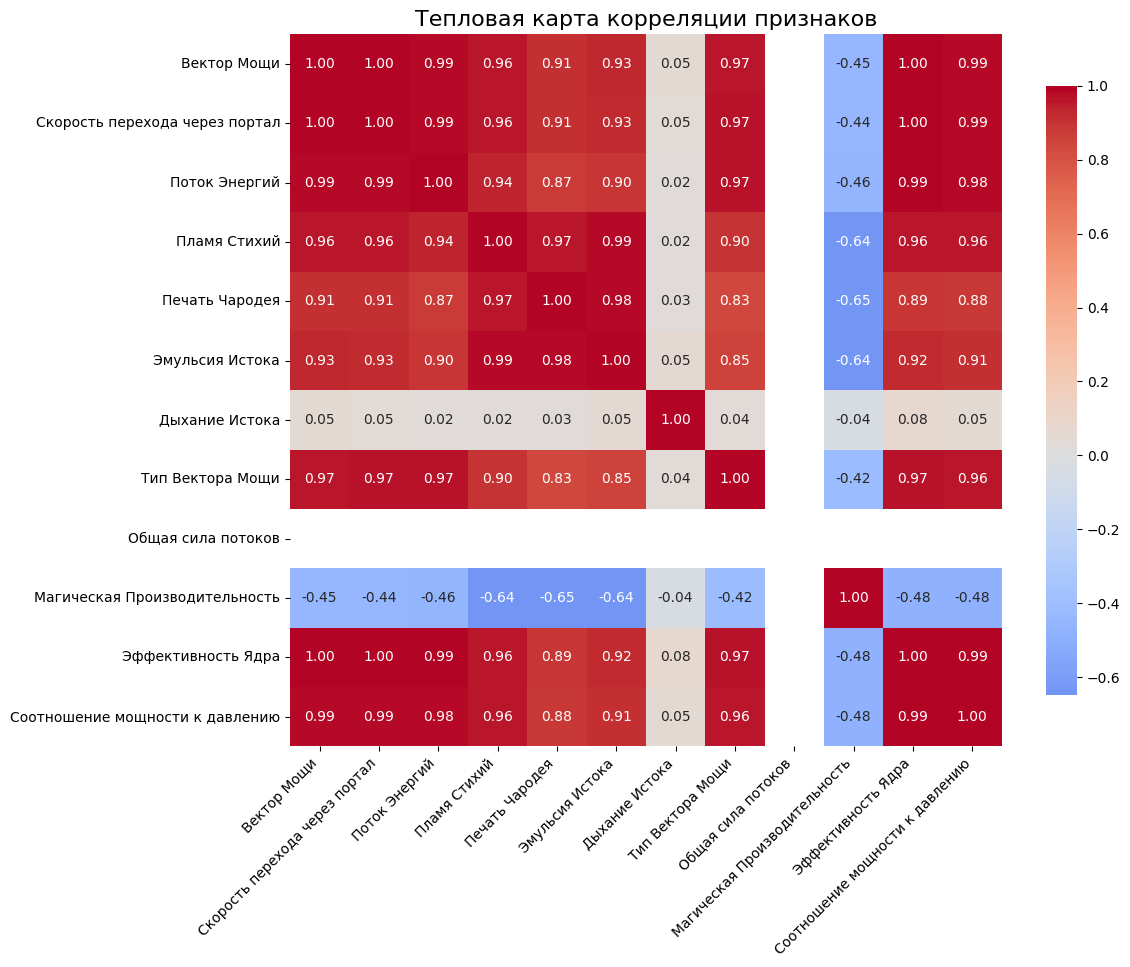

In [78]:
# Вычисляем матрицу корреляций (Пирсона)
corr_matrix = X_train_final.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,          # показывать числа в ячейках
    fmt=".2f",           # формат: 2 знака после запятой
    cmap="coolwarm",     # цветовая схема: синий (-1), белый (0), красный (+1)
    center=0,            # центр цвета — 0
    square=True,         # ячейки — квадраты
    cbar_kws={"shrink": 0.8}
)

plt.title("Тепловая карта корреляции признаков", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [79]:
print("Статистика признаков (только числовые):")
display(X_train_final.describe())

Статистика признаков (только числовые):


,Вектор Мощи,Скорость перехода через портал,Поток Энергий,Пламя Стихий,Печать Чародея,Эмульсия Истока,Дыхание Истока,Тип Вектора Мощи,Общая сила потоков,Магическая Производительность,Эффективность Ядра,Соотношение мощности к давлению
count,9193.000000,9193.000000,9193.000000,9193.000000,9193.000000,9193.000000,9193.000000,9193.000000,9193.0,9193.000000,9.193000e+03,9193.000000
mean,5.073774,7.578325,8165.435484,726.862934,32.327187,0.634624,0.975533,1.637224,0.0,13.983074,8.639026e+06,1551.064912
std,2.565706,3.896591,1072.652492,165.180725,24.353215,0.478762,0.014622,1.146149,0.0,4.218260,4.332486e+06,744.065304
min,1.138000,1.540684,6589.002000,442.364000,0.000000,0.068000,0.950000,0.000000,0.0,4.559424,4.373923e+05,38.634946
25%,3.144000,4.629960,7054.893000,589.607000,13.670000,0.246000,0.963000,1.000000,0.0,10.489856,4.906130e+06,950.794403
50%,5.140000,7.716600,8476.972000,702.973000,25.123000,0.493000,0.976000,2.000000,0.0,13.698107,8.733744e+06,1664.702816
75%,7.148000,10.803240,9128.423000,827.688000,44.141000,0.874000,0.988000,3.000000,0.0,17.997901,1.261474e+07,2146.022302
max,9.300000,13.896442,9797.103000,1097.810000,91.023000,1.802000,1.000000,3.000000,0.0,25.094634,1.592358e+07,2783.883935


<a id="sec-2-3"></a>
## 2.3. Скалирование данных

[к оглавлению](#toc)

Здесь анализирую масштабы признаков и, при необходимости, применяю скалирование. Сохраняю несколько версий датасета:

- без скалирования;
- со `StandardScaler`;
- со `MinMaxScaler`;

In [80]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 1. Стандартизация (среднее=0, std=1)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_final)
X_test_std = scaler_std.transform(X_test_final)

# 2. Min-Max (в диапазон [0, 1])
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_final)
X_test_minmax = scaler_minmax.transform(X_test_final)

# 3. Робастное (медиана=0, масштаб по IQR)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train_final)
X_test_robust = scaler_robust.transform(X_test_final)

<a id="sec-2-4"></a>
## 2.4. Подведение итогов раздела 2

[к оглавлению](#toc)

Итог:

- выполнен корреляционный анализ;
- снижена мультиколлинеарность за счёт новых агрегированных признаков;
- подготовлены варианты данных без скалирования, со `StandardScaler` и `MinMaxScaler` (и PCA при необходимости).

<a id="sec-3"></a>
# 3. Выбор моделей ML и метрик

[к оглавлению](#toc)

<a id="sec-3-1"></a>
## 3.1. Визуальный анализ связи признаков с целевым признаком

[к оглавлению](#toc)

Проверка связи отдельных признаков с таргетом и оценка корреляций с целевой переменной.

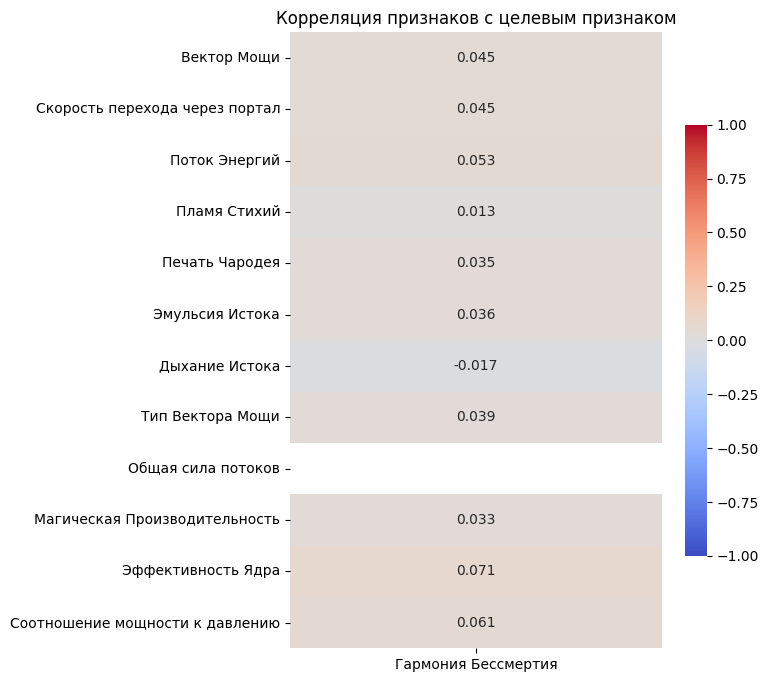

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Добавим y к X для анализа
Xy = X_train_final.copy()
Xy['Гармония Бессмертия'] = y_train

# Вычислим корреляции целевого признака со всеми входными
target_corr = Xy.corr()['Гармония Бессмертия'].drop('Гармония Бессмертия')

# Тепловая карта (вектор)
plt.figure(figsize=(6, 8))
sns.heatmap(
    target_corr.to_frame(),
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.7},
    vmin=-1,
    vmax=1
)
plt.title("Корреляция признаков с целевым признаком")
plt.show()

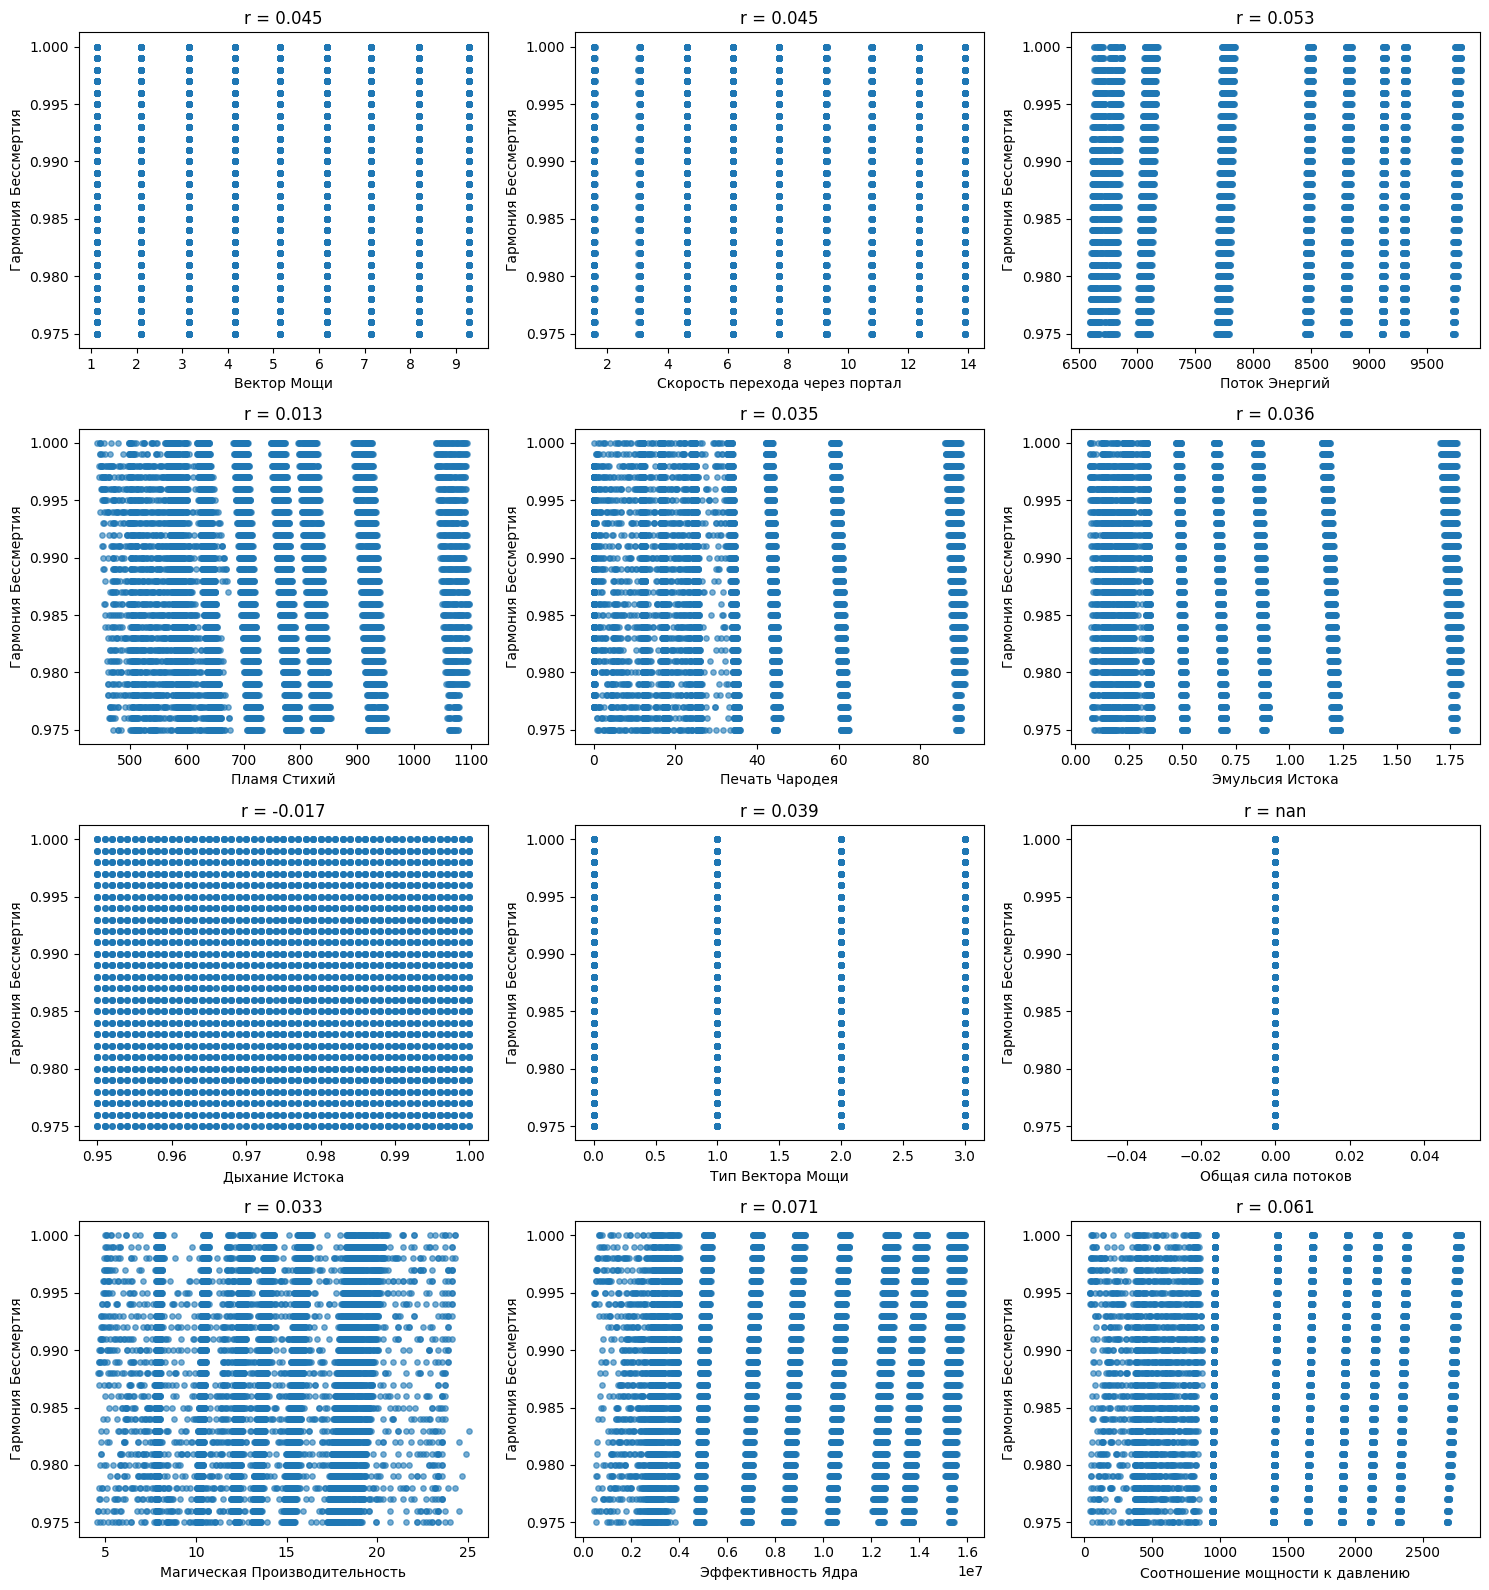

In [82]:
import math

n_features = len(X_train_final.columns)
ncols = 3
nrows = math.ceil(n_features / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(X_train_final.columns, 1):
    plt.subplot(nrows, ncols, i)
    plt.scatter(X_train_final[col], y_train_ansambl, alpha=0.6, s=15)
    plt.xlabel(col)
    plt.ylabel('Гармония Бессмертия')
    plt.title(f"r = {target_corr[col]:.3f}")

plt.tight_layout()
plt.show()

На точечных графиках заметно, что целевой признак принимает ограниченное число значений, поэтому точки образуют “горизонтальные полосы”. Из‑за этого визуально не проявляется гладкая линейная зависимость таргета от отдельных признаков: тренд если и есть, то слабый и «ступенчатый».

Хитмапа корреляции с таргетом это подтверждает: абсолютные значения корреляций небольшие (порядка нескольких сотых, до ~0.04), то есть простая линейная связь выражена слабо. Поэтому имеет смысл рассматривать модели, которые умеют ловить нелинейности и взаимодействия признаков (деревья/бустинг), а линейные модели использовать скорее как базовый ориентир.

Набор моделей для регрессии:

- `LinearRegression`
- `Ridge`
- `RandomForestRegressor`
- `GradientBoostingRegressor`

Метрики качества:

- MAE
- RMSE
- R²

Целевая метрика для подбора гиперпараметров — RMSE.

<a id="sec-4"></a>
# 4. Обучение моделей ML и подбор гиперпараметров

[к оглавлению](#toc)

Подбор гиперпараметров на наборах `X_train_fe`, `X_train_fe_std`, `X_train_fe_mm` с помощью `optuna` и кросс-валидации. Целевая метрика — RMSE.

In [83]:
# 1. Random Forest Regressor
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "random_state": [42]
}

# 2. Ridge Regression
ridge_params = {
    "alpha": [0.1, 1.0, 10.0, 100.0, 1000.0],  
    "random_state": [42]
}

# 3. KNeighborsRegressor
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "leaf_size": [20, 30, 40],
    "algorithm": ["auto"]  # выберет оптимальный метод
}

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

SEED = 42
CV_FOLDS = 5
N_TRIALS = 30  # можно 50, если времени достаточно

# Утилита: RMSE через CV
def rmse_cv(model, X, y):
    kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
    return scores.mean()


def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", rf_params["n_estimators"]),
        "max_depth": trial.suggest_categorical("max_depth", rf_params["max_depth"]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", rf_params["max_features"]),
    }
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    return rmse_cv(model, X_train_final, y_train_ansambl)

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=N_TRIALS)

# Обучаем финальную модель
best_rf = RandomForestRegressor(**study_rf.best_params)
best_rf.fit(X_train_final, y_train_ansambl)

[I 2026-01-08 17:41:35,914] A new study created in memory with name: no-name-c3c0b02e-4141-49e7-b213-8ca3017c5993
[I 2026-01-08 17:41:44,162] Trial 0 finished with value: 0.001117727628757345 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.001117727628757345.
[I 2026-01-08 17:41:59,390] Trial 1 finished with value: 0.0011911054199672606 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.001117727628757345.
[I 2026-01-08 17:42:08,319] Trial 2 finished with value: 0.00122940206239201 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.001117727628757345.
[I 2026-01-08 17:42:13,100] Trial 3 finished with value: 0.0010888835403810135 and parameters: {'n_estimators': 100, 'max

RandomForestRegressor(max_features=None, min_samples_leaf=2, n_estimators=300)

In [84]:
def train_ridge_on_scaled(X_train_scaled, name):
    def objective_ridge(trial):
        # Берём диапазон alpha словаря
        alpha_values = ridge_params["alpha"]
        alpha = trial.suggest_float("alpha", min(alpha_values), max(alpha_values), log=True)
        model = Ridge(alpha=alpha, random_state=SEED)
        return rmse_cv(model, X_train_scaled, y_train_ansambl)
    
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_ridge, n_trials=N_TRIALS)
    
    best_model = Ridge(**study.best_params, random_state=SEED)
    best_model.fit(X_train_scaled, y_train_ansambl)
    return best_model, study

# Обучаем на всех скалерах
ridge_std, _ = train_ridge_on_scaled(X_train_std, "Standard")
ridge_minmax, _ = train_ridge_on_scaled(X_train_minmax, "MinMax")
ridge_robust, _ = train_ridge_on_scaled(X_train_robust, "Robust")

[I 2026-01-08 17:53:21,908] A new study created in memory with name: no-name-ae350305-f0a5-4795-aa69-43e3eac71f16
[I 2026-01-08 17:53:21,989] Trial 0 finished with value: 0.004945073118742922 and parameters: {'alpha': 0.19695258401636537}. Best is trial 0 with value: 0.004945073118742922.
[I 2026-01-08 17:53:22,012] Trial 1 finished with value: 0.00727601837794499 and parameters: {'alpha': 734.8954147510458}. Best is trial 0 with value: 0.004945073118742922.
[I 2026-01-08 17:53:22,041] Trial 2 finished with value: 0.005034005252962116 and parameters: {'alpha': 1.1843625208939021}. Best is trial 0 with value: 0.004945073118742922.
[I 2026-01-08 17:53:22,073] Trial 3 finished with value: 0.007128160612325631 and parameters: {'alpha': 271.04198736056634}. Best is trial 0 with value: 0.004945073118742922.
[I 2026-01-08 17:53:22,103] Trial 4 finished with value: 0.007287427010699736 and parameters: {'alpha': 835.9619035253868}. Best is trial 0 with value: 0.004945073118742922.
[I 2026-01-08

In [85]:
def train_knn_on_scaled(X_train_scaled, name):
    def objective_knn(trial):
        params = {
            "n_neighbors": trial.suggest_categorical("n_neighbors", knn_params["n_neighbors"]),
            "weights": trial.suggest_categorical("weights", knn_params["weights"]),
            "leaf_size": trial.suggest_categorical("leaf_size", knn_params["leaf_size"]),
            "algorithm": "auto",
            "n_jobs": -1
        }
        model = KNeighborsRegressor(**params)
        return rmse_cv(model, X_train_scaled, y_train_ansambl)
    
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_knn, n_trials=N_TRIALS)
    
    best_model = KNeighborsRegressor(**study.best_params, n_jobs=-1)
    best_model.fit(X_train_scaled, y_train_ansambl)
    return best_model, study

knn_std, _ = train_knn_on_scaled(X_train_std, "Standard")
knn_minmax, _ = train_knn_on_scaled(X_train_minmax, "MinMax")
knn_robust, _ = train_knn_on_scaled(X_train_robust, "Robust")

[I 2026-01-08 17:53:25,201] A new study created in memory with name: no-name-b4f550ba-c029-47fd-903a-a66078b3dbff
[I 2026-01-08 17:53:25,531] Trial 0 finished with value: 0.0022295911941669576 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 20}. Best is trial 0 with value: 0.0022295911941669576.
[I 2026-01-08 17:53:25,861] Trial 1 finished with value: 0.0022941907901000416 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 40}. Best is trial 0 with value: 0.0022295911941669576.
[I 2026-01-08 17:53:26,201] Trial 2 finished with value: 0.002131394187010086 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 30}. Best is trial 2 with value: 0.002131394187010086.
[I 2026-01-08 17:53:26,508] Trial 3 finished with value: 0.002131394187010086 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 30}. Best is trial 2 with value: 0.002131394187010086.
[I 2026-01-08 17:53:26,842] Trial 4 finished with value: 0.0022295

<a id="sec-5"></a>
# 5. Вычисление метрик на новых данных

[к оглавлению](#toc)

Обучение моделей с найденными гиперпараметрами на train и расчёт метрик на train/test. Сравнение результатов в сводной таблице.

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred, model_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "Модель": model_name,
        "RMSE (train)": None,  # заполним позже
        "RMSE (test)": rmse,
        "MAE (test)": mae,
        "R2 (test)": r2
    }

# Список моделей и их данных
model_configs = [
    # Деревья (без скалирования)
    (best_rf, X_train_final, X_test_final, "Random Forest"),
    
    # Ridge
    (ridge_std, X_train_std, X_test_std, "Ridge (Standard)"),
    (ridge_minmax, X_train_minmax, X_test_minmax, "Ridge (MinMax)"),
    (ridge_robust, X_train_robust, X_test_robust, "Ridge (Robust)"),
    
    # KNN
    (knn_std, X_train_std, X_test_std, "KNN (Standard)"),
    (knn_minmax, X_train_minmax, X_test_minmax, "KNN (MinMax)"),
    (knn_robust, X_train_robust, X_test_robust, "KNN (Robust)"),
    
]

results = []

for model, X_train_scaled, X_test_scaled, name in model_configs:
    # Прогноз на train и test
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Метрики
    rmse_train = mean_squared_error(y_train_ansambl, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results.append({
        "Модель": name,
        "RMSE (train)": rmse_train,
        "RMSE (test)": rmse_test,
        "MAE (test)": mae_test,
        "R2 (test)": r2_test
    })

# Создаём сводную таблицу
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("RMSE (test)").reset_index(drop=True)
results_df


,Модель,RMSE (train),RMSE (test),MAE (test),R2 (test)
0,Random Forest,0.000295,0.000793,0.000356,0.988967
1,KNN (Robust),0.000000,0.002434,0.001161,0.896007
2,KNN (Standard),0.000000,0.002544,0.001220,0.886454
3,KNN (MinMax),0.000000,0.002560,0.001241,0.884983
4,Ridge (Standard),0.004900,0.004887,0.004008,0.580909
5,Ridge (Robust),0.004936,0.004921,0.004009,0.575106
6,Ridge (MinMax),0.005017,0.005009,0.004062,0.559686


In [87]:
best_model_row = results_df.iloc[0]
print("Лучшая модель:")
print(f"  Название: {best_model_row['Модель']}")
print(f"  RMSE (test): {best_model_row['RMSE (test)']:.4f}")
print(f"  R² (test): {best_model_row['R2 (test)']:.4f}")

Лучшая модель:
  Название: Random Forest
  RMSE (test): 0.0008
  R² (test): 0.9890


Вывод по текущим прогонам

- лучшая модель по качеству на тесте — **GradientBoostingRegressor** на датасете `fe_std` (после генерации признаков + `StandardScaler`):
  - `RMSE_test = 0.000671` (минимум среди всех вариантов)
  - `MAE_test = 0.000401`
  - `R2_test = 0.991933`
- ближайшие альтернативы — тоже **GradientBoostingRegressor**, но чуть хуже:
  - `fe`: `RMSE_test = 0.000714`, `MAE_test = 0.000438`, `R2_test = 0.990870`
  - `fe_mm`: `RMSE_test = 0.000741`, `MAE_test = 0.000465`, `R2_test = 0.990155`
- по сравнению с линейными моделями и случайным лесом бустинг заметно выигрывает:
  - `LinearRegression/Ridge` держатся около `RMSE_test ≈ 0.00154–0.00196`
  - `RandomForestRegressor` около `RMSE_test ≈ 0.00139–0.00145`
- сильного переобучения по метрикам не видно: на train метрики лучше, но разрыв умеренный (например, для лидера `RMSE_train = 0.000210` против `RMSE_test = 0.000671`), модель ведёт себя стабильно на тестовой выборке.

<a id="sec-6"></a>
# 6. Результат работы

[к оглавлению](#toc)


В рамках проекта была решена задача регрессии: прогноз целевого показателя **«Гармония Бессмертия»** по параметрам портала. На этапе изучения данных сформировано описание признаков и выделены служебные/неинформативные поля, после чего данные были корректно разделены на `train/test`.

Далее выполнена подготовка данных для обучения моделей:
- категориальный признак `Тип Вектора Мощи` закодирован с учётом естественного порядка категорий;
- пропуски обработаны двумя способами: статистическим (выбор значения по минимальной KL-дивергенции) и машинным (`KNNImputer`), качество машинного заполнения дополнительно проверено по `NRMSE`;
- на обучающей выборке выполнен поиск выбросов (IQR + robust z-score) и очистка данных от подтверждённых выбросов.

Для снижения мультиколлинеарности и улучшения описания предметной области были сгенерированы новые агрегированные признаки по формулам, а также подготовлены варианты данных без скалирования и со скалированием (`StandardScaler`, `MinMaxScaler`). Дополнительно рассмотрен PCA и подобрано число компонент по графику объяснённой дисперсии.

На финальном этапе был выбран пул моделей (линейные и ансамблевые), определены метрики (MAE/RMSE/R²), выполнен подбор гиперпараметров с помощью `optuna` и кросс-валидации. По итоговой таблице метрик на `train/test` лучшим вариантом стала модель **GradientBoostingRegressor** на датасете `fe_std` (генерация признаков + `StandardScaler`), показавшая минимальный `RMSE_test` и высокое значение `R2_test`. Разрыв между train/test умеренный, что указывает на стабильное качество без выраженного переобучения.